In [1]:
"""" 
compute wind power over the North Atlantic (including GOM) from
(1) RTOFS surface.now hourly analysis data & 
(2) GFS sfc data (forecast hours: 1-6)
"""
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
from scipy import interpolate
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from convert_dir import vector_dir_to_from
from mystats import bandpass
from values_to_colors import values_to_rgba
sys.path.insert(0, path_nhchi+'area-master')
# "area" library is from https://github.com/scisco/area
from area import area

In [2]:
year = '2023'
datelim = [datetime.datetime(int(year),9,1), datetime.datetime(int(year),9,30)]
pathG = '/Users/chi/Documents/projects/sd-ni-wp/check_model/check_GFS/GFS.merge.sfc.'+\
    datelim[0].strftime('%Y%m%d')+'-'+datelim[-1].strftime('%Y%m%d')+'.nc'
pathR = '/Users/chi/Documents/projects/sd-ni-wp/check_model/check_RTOFS/RTOFS.merge.surface.now.'+\
    datelim[0].strftime('%Y%m%d')+'-'+datelim[-1].strftime('%Y%m%d')+'.nc'

dsG = nc.Dataset(pathG)
dsR = nc.Dataset(pathR)
print(dsG)
print('====================')
print(dsR)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for GFS sfc data between 20230901 01Z and 20231001 00Z
Here the forecast hour 1 ~ 6 is aggregated for each forecast cycle (6 hour) for a hourly time series.
    subtitle: Only selected variables for are merged here. The data is hourly with ~0.117 deg horizontal resolution.
    dimensions(sizes): time(672), longitude(615), latitude(329)
    variables(dimensions): float64 time(time), float64 LON(latitude, longitude), float64 LAT(latitude, longitude), float64 UFLX_AVE(time, latitude, longitude), float64 VFLX_AVE(time, latitude, longitude)
    groups: 
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for RTOFS fromsurface.now.20230902.nc to  and surface.now.20231001.nc 
Note that the time of each daily file in /Volumes/disk3/projects/tc2022/tc2023/RTOFS/study_area/ 
is one day prior to the date on showing 

In [3]:
print('shape of RTOFS velocity, lon:',dsR['U_VELOCITY'].shape, dsR['LONGITUDE'].shape)
print('min & max of RTOFS u-velocity',np.nanmin(dsR['U_VELOCITY'][:]),np.nanmax(dsR['U_VELOCITY'][:]))
print('='*30)
print('shape of GFS UFLX, lon:',dsG['UFLX_AVE'].shape, dsG['LON'].shape)
print('min & max of GFS UFLX',np.nanmin(dsG['UFLX_AVE'][:]),np.nanmax(dsG['UFLX_AVE'][:]))

shape of RTOFS velocity, lon: (648, 1, 551, 901) (551, 901)
min & max of RTOFS u-velocity -3.4128530025482178 1.2676506002282294e+30
shape of GFS UFLX, lon: (672, 329, 615) (329, 615)
min & max of GFS UFLX -4.999680995941162 5.723142623901367


In [4]:
''' Read RTOFS data '''
## read data & set limits of the box
LON_R = dsR['LONGITUDE'][:]
LON_R[LON_R> 180] = LON_R[LON_R> 180]-360
LAT_R = dsR['LATITUDE'][:]
U_R = np.squeeze( dsR['U_VELOCITY'][:] )
V_R = np.squeeze( dsR['V_VELOCITY'][:] )
U_R[U_R> 1e3] = np.nan # Fill_value is something like 1e30
V_R[V_R> 1e3] = np.nan
dtime_R = np.array([datetime.datetime.fromtimestamp(item) for item in dsR['time'][:]])
print('shape of LON_R, LAT_R, V_R:',LON_R.shape, LAT_R.shape, V_R.shape)
# dsR.close()
print('RTOFS longitude & latitude limits:',np.min(LON_R),np.max(LON_R),np.min(LAT_R),np.max(LAT_R))
print('RTOFS time limits:',np.min(dtime_R),np.max(dtime_R))
print('RTOFS u limits:',np.nanmin(U_R),np.nanmax(U_R))
print('RTOFS v limits:',np.nanmin(V_R),np.nanmax(V_R))

shape of LON_R, LAT_R, V_R: (551, 901) (551, 901) (648, 551, 901)
RTOFS longitude & latitude limits: -101.9200439453125 -29.9200439453125 7.577810764312744 45.77324676513672
RTOFS time limits: 2023-09-04 00:00:00 2023-09-30 23:00:00
RTOFS u limits: -3.4128530025482178 2.7816739082336426
RTOFS v limits: -2.850588798522949 3.0253148078918457


In [5]:
''' Give RTOFS a lon/ lat limits and plot time series of u/v
'''
# lonlim = np.array([-98, -30])
# latlim = np.array([7.5, 40])
# ### 
# ilon = np.where( (LON_R[0,:]>= lonlim[0]) & (LON_R[0,:]< lonlim[1]) )[0]
# ilat = np.where( (LAT_R[:,0]>= latlim[0]) & (LAT_R[:,0]< latlim[1]) )[0]
# print('lengths of ilat, ilon:',len(ilat),len(ilon))

' Give RTOFS a lon/ lat limits and plot time series of u/v\n'

Lat_R[ilat]: (551,)


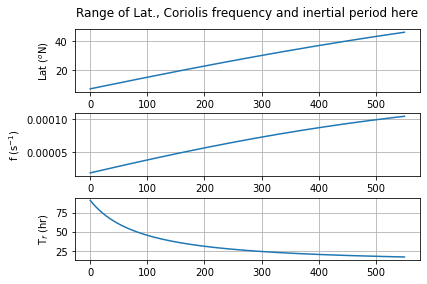

In [6]:
''' For each latitude, give a frequency limit to filter timeseries to NI band 
(try 0.8f-1.2f for each latitudes)'''
u_bp = np.nan*np.ones( (len(dtime_R), LON_R.shape[0], LON_R.shape[1]) )
v_bp = u_bp.copy()
f_lat = 2*(2*np.pi/86400)*np.sin(LAT_R[:,0]/180*np.pi) # 1/s
T_lat = 2*np.pi/f_lat/3600 # hr
print('Lat_R[ilat]:',LAT_R[:,0].shape)
plt.subplot(3,1,1)
plt.plot(LAT_R[:,0]); plt.ylabel('Lat ($^o$N)'); plt.grid()
plt.subplot(3,1,2)
plt.plot(f_lat); plt.ylabel('f (s$^{-1}$)'); plt.grid()
plt.subplot(3,1,3)
plt.plot(T_lat); plt.ylabel('T$_f$ (hr)'); plt.grid()
plt.suptitle('Range of Lat., Coriolis frequency and inertial period here')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)

In [7]:
''' go through each RTOF grid and compute bandpass (NI) current velocities 
(~1 mins per latitude with 40 deg longitudes, ~1.8 mins per latitude with 73 deg longitudes)''' 
n_f = np.array([0.8,1.2])
dsec_RTOFS = (dtime_R[1]-dtime_R[0]).total_seconds()
###
for icnt in range( LAT_R.shape[0] ):
    # print(icnt, lat_i)
    f_bp = np.array([n_f[0]*f_lat[icnt], n_f[1]*f_lat[icnt]])
    bp_sec = 2*np.pi/f_bp
    for jcnt in range( LON_R.shape[1] ):
        # print(jcnt, lon_j)
        if np.sum(np.isnan(U_R[:,icnt,jcnt])) == 0:
            u_bp[:,icnt,jcnt],_,_,_,_ = bandpass( np.squeeze( U_R[:,icnt,jcnt] ), dsec_RTOFS,bp_sec[0],bp_sec[1],2 )
            v_bp[:,icnt,jcnt],_,_,_,_ = bandpass( np.squeeze( V_R[:,icnt,jcnt] ), dsec_RTOFS,bp_sec[0],bp_sec[1],2 )
            # print('Done with',LAT_R[icnt,0],LON_R[0,jcnt])
    print('Done with all longitudes for',LAT_R[icnt,0])
    # break

Done with all longitudes for 7.577810764312744
Done with all longitudes for 7.657104969024658
Done with all longitudes for 7.736384391784668
Done with all longitudes for 7.815648555755615
Done with all longitudes for 7.894897937774658
Done with all longitudes for 7.974132061004639
Done with all longitudes for 8.053350448608398
Done with all longitudes for 8.132554054260254
Done with all longitudes for 8.21174144744873
Done with all longitudes for 8.290913581848145
Done with all longitudes for 8.37006950378418
Done with all longitudes for 8.449209213256836
Done with all longitudes for 8.528332710266113
Done with all longitudes for 8.607439994812012
Done with all longitudes for 8.686531066894531
Done with all longitudes for 8.765604972839355
Done with all longitudes for 8.844661712646484
Done with all longitudes for 8.923702239990234
Done with all longitudes for 9.002724647521973
Done with all longitudes for 9.081730842590332
Done with all longitudes for 9.16071891784668
Done with all lo

In [8]:
''' Read GFS data '''
LON_G = dsG['LON'][:]
LON_G[LON_G> 180] = LON_G[LON_G> 180]-360
LAT_G = dsG['LAT'][:]
UFLX_AVE = np.squeeze( dsG['UFLX_AVE'][:] )
VFLX_AVE = np.squeeze( dsG['VFLX_AVE'][:] )
UFLX_AVE[UFLX_AVE> 1e3] = np.nan
VFLX_AVE[VFLX_AVE> 1e3] = np.nan
dtime_G = np.array([datetime.datetime.fromtimestamp(item) for item in dsG['time'][:]])
print('shape of LON_G, LAT_G, VFLX_AVE:',LON_G.shape, LAT_G.shape, VFLX_AVE.shape)
print('GFS longitude & latitude limits:',np.min(LON_G),np.max(LON_G),np.min(LAT_G),np.max(LAT_G))
print('GFS time limits:',np.min(dtime_G),np.max(dtime_G))
print('GFS uflx limits:',np.nanmin(UFLX_AVE),np.nanmax(UFLX_AVE))
print('GFS vflx limits:',np.nanmin(VFLX_AVE),np.nanmax(VFLX_AVE))
# dsG.close()

shape of LON_G, LAT_G, VFLX_AVE: (329, 615) (329, 615) (672, 329, 615)
GFS longitude & latitude limits: -101.953125 -30.0 7.556133668527031 45.98112279618861
GFS time limits: 2023-09-01 01:00:00 2023-10-01 00:00:00
GFS uflx limits: -4.999680995941162 5.723142623901367
GFS vflx limits: -5.376657962799072 4.498466491699219


In [9]:
''' Try interpolate surface zonal momentum flux to RTOFS spatial grids using interpolate.griddata 
    (<2 mins per one day for the entire domain (103W-30W, 7.5N-46N))
    In contrast, it takes ~4.5 mins per day to interpolate to RTOFS spatial grids for domain: 98W~30W, 7.5N~40N'''
print('LON_G shape:',LON_G.shape,'LON_R shape:',LON_R.shape)
UFLX_AVE_onR = np.nan*np.ones( (len(dtime_R),LON_R.shape[0],LON_R.shape[1]) )
VFLX_AVE_onR = UFLX_AVE_onR.copy()
for t in range( len(dtime_R) ):
    it_G = np.where( dtime_G == dtime_R[t] )[0]
    if len(it_G) == 1:
        Z = interpolate.griddata((LON_G.flatten(), LAT_G.flatten()), UFLX_AVE[it_G,:,:].flatten(), \
                                 (LON_R.flatten(), LAT_R.flatten()), method='linear')
        UFLX_AVE_onR[t,:,:] = np.reshape( Z, (LON_R.shape[0],LON_R.shape[1]) )
        Z = interpolate.griddata((LON_G.flatten(), LAT_G.flatten()), VFLX_AVE[it_G,:,:].flatten(), \
                                 (LON_R.flatten(), LAT_R.flatten()), method='linear')
        VFLX_AVE_onR[t,:,:] = np.reshape( Z, (LON_R.shape[0],LON_R.shape[1]) )
        print('Done griddata for',dtime_R[t],dtime_G[it_G],', t=',t,', it_G=',it_G)

LON_G shape: (329, 615) LON_R shape: (551, 901)
Done griddata for 2023-09-04 01:00:00 [datetime.datetime(2023, 9, 4, 1, 0)] , t= 1 , it_G= [24]
Done griddata for 2023-09-04 02:00:00 [datetime.datetime(2023, 9, 4, 2, 0)] , t= 2 , it_G= [25]
Done griddata for 2023-09-04 03:00:00 [datetime.datetime(2023, 9, 4, 3, 0)] , t= 3 , it_G= [26]
Done griddata for 2023-09-04 04:00:00 [datetime.datetime(2023, 9, 4, 4, 0)] , t= 4 , it_G= [27]
Done griddata for 2023-09-04 05:00:00 [datetime.datetime(2023, 9, 4, 5, 0)] , t= 5 , it_G= [28]
Done griddata for 2023-09-04 06:00:00 [datetime.datetime(2023, 9, 4, 6, 0)] , t= 6 , it_G= [29]
Done griddata for 2023-09-04 07:00:00 [datetime.datetime(2023, 9, 4, 7, 0)] , t= 7 , it_G= [30]
Done griddata for 2023-09-04 08:00:00 [datetime.datetime(2023, 9, 4, 8, 0)] , t= 8 , it_G= [31]
Done griddata for 2023-09-04 09:00:00 [datetime.datetime(2023, 9, 4, 9, 0)] , t= 9 , it_G= [32]
Done griddata for 2023-09-04 10:00:00 [datetime.datetime(2023, 9, 4, 10, 0)] , t= 10 , i

LON_R shape: (551, 901) LON_G shape: (329, 615)
LON_R range: -101.9200439453125 - -29.9200439453125
LAT_R range: 7.577810764312744 - 45.77324676513672
UFLX_AVE_onR, u_bp shape: (648, 551, 901) (648, 551, 901)
0.002651375015414971
25 48


<Figure size 432x288 with 0 Axes>

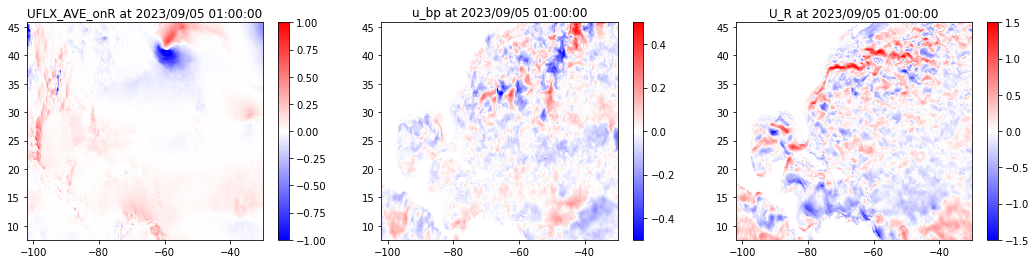

In [17]:
''' print data shapes to be written to files '''
print('LON_R shape:',LON_R.shape,'LON_G shape:',LON_G.shape)
print('LON_R range:',LON_R[0,0],'-',LON_R[0,-1])
print('LAT_R range:',LAT_R[0,0],'-',LAT_R[-1,0])
print('UFLX_AVE_onR, u_bp shape:',UFLX_AVE_onR.shape,u_bp.shape)
print(np.sum(np.isnan(UFLX_AVE_onR))/len(UFLX_AVE_onR.flatten()))
''' plot '''
t_R = 25
it_G = np.where( dtime_G == dtime_R[t_R] )[0][0]
dtime_str = dtime_R[t_R].strftime('%Y/%m/%d %H:%M:%S')
print(t_R, it_G)
plt.clf()
fig = plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.pcolormesh(LON_R, LAT_R, UFLX_AVE_onR[t_R,:,:], vmin=-1, vmax=1, cmap='bwr')
plt.title('UFLX_AVE_onR at '+dtime_str)
plt.subplot(1,3,2)
plt.pcolormesh(LON_R, LAT_R, u_bp[t_R,:,:], vmin=-0.5, vmax=0.5, cmap='bwr')
plt.title('u_bp at '+dtime_str)
plt.subplot(1,3,3)
plt.pcolormesh(LON_R, LAT_R, U_R[it_G,:,:], vmin=-1.5, vmax=1.5, cmap='bwr')
plt.title('U_R at '+dtime_str)
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.colorbar()

In [19]:
''' write momentum flux (on RTOFS spatial grids) & RTOFS bandpass (NI) surface currents '''
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
tlim_str = dtime_R[0].strftime('%Y%m%d')+'-'+dtime_R[-1].strftime('%Y%m%d')
xylim_str = '{:.1f}N-{:.1f}N_{:.1f}-{:.1f}'.format(LAT_R[0,0],LAT_R[-1,0],LON_R[0,0],LON_R[0,-1])
ncfname_out = 'GFS-momFlux(RTOFS-grids)_RTOFS-NIUV({:.2f}f-{:.2f}f)_'.format(n_f[0],n_f[1])+tlim_str+'_'+xylim_str+'.nc'
print(tlim_str)
print(xylim_str)
print(ncfname_out)
ncfile = nc.Dataset(ncfname_out,mode='w',format='NETCDF4_CLASSIC') 
print(ncfile)
### creating dimensions
time_dim = ncfile.createDimension('time', len(dtime_R)) # unlimited axis (can be appended to).
lon_dim = ncfile.createDimension('longitude', UFLX_AVE_onR.shape[2] )
lat_dim = ncfile.createDimension('latitude', UFLX_AVE_onR.shape[1] )
for dim in ncfile.dimensions.items():
    print(dim)
### creating attributes
ncfile.title='GFS momentum flux on RTOFS spatial grids & RTOFS bandpass (NI:{:.2f}f-{:.2f}f) surface currents \n'.format(n_f[0],n_f[1])+\
    'for '+tlim_str+', '+xylim_str
print(ncfile.title)
ncfile.subtitle="Use scipy.interpolate.griddata to linearly interpolate GFS momentum flux to RTOFS spatial grids."
print(ncfile.subtitle)
print(ncfile)
### move the writing data to new variables
if isinstance(UFLX_AVE_onR, np.ndarray):
    print('momentum flux variables are np array')
    UFLX_AVE_onR_out = UFLX_AVE_onR
    VFLX_AVE_onR_out = VFLX_AVE_onR
if isinstance(u_bp, np.ndarray):
    print('bandpass u/v variables are np array')
    u_bp_out = u_bp
    v_bp_out = v_bp

20230904-20230930
7.6N-45.8N_-101.9--29.9
GFS-momFlux(RTOFS-grids)_RTOFS-NIUV(0.80f-1.20f)_20230904-20230930_7.6N-45.8N_-101.9--29.9.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
('time', <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 648)
('longitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 901)
('latitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 551)
GFS momentum flux on RTOFS spatial grids & RTOFS bandpass (NI:0.80f-1.20f) surface currents 
for 20230904-20230930, 7.6N-45.8N_-101.9--29.9
Use scipy.interpolate.griddata to linearly interpolate GFS momentum flux to RTOFS spatial grids.
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: GFS momentum flux on RTOFS spatial grids & RTOFS bandpass (NI:0.80f-1.20f) surface currents 
for 20230904-20230930, 7.6N-45

In [20]:
### Creating variables
time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'seconds since '+year+'-01-01'
time.long_name = 'time'
lon = ncfile.createVariable('longitude', np.float64, ('longitude',))
lon.units = 'degrees_E'
lon.long_name = 'longitude'
lat = ncfile.createVariable('latitude', np.float64, ('latitude',))
lat.units = 'degrees_M'
lat.long_name = 'latitude'
### 3D variables
vars_names_4nc = ['UFLX_AVE','VFLX_AVE','ucur_bp','vcur_bp']
long_names = ['GFS surface zonal momentum flux','GFS surface meridional momentum flux','RTOFS bandpassed ucur-vel','RTOFS bandpassed vcur-vel']
units = ['N/m**2','N/m**2','m/s','m/s']
### 3: (time, latitude, longitude)
dim_cat = [3,3,3,3]
for i, vname_nc in enumerate( vars_names_4nc ):
    ### create variables with respective dimensions categorized by dim_cat
    if dim_cat[i] == 3:
        str_exec = vname_nc + "= ncfile.createVariable('" + vname_nc + "', np.float64, ('" + 'time' + "','"+ 'latitude' +"','"+ 'longitude' +"'))"
        exec(str_exec)
        print(i,str_exec)
    ### add attributes
    for item in units:
        str_exec = vname_nc + ".units = '"+ item + "'"
        exec(str_exec)
    for item in long_names:
        str_exec = vname_nc + ".long_name = '"+ item + "'"
        exec(str_exec)

0 UFLX_AVE= ncfile.createVariable('UFLX_AVE', np.float64, ('time','latitude','longitude'))
1 VFLX_AVE= ncfile.createVariable('VFLX_AVE', np.float64, ('time','latitude','longitude'))
2 ucur_bp= ncfile.createVariable('ucur_bp', np.float64, ('time','latitude','longitude'))
3 vcur_bp= ncfile.createVariable('vcur_bp', np.float64, ('time','latitude','longitude'))


In [21]:
### writing data
# Note: the ":" is necessary in these "write" statements
vars_names_out = ['UFLX_AVE_onR_out','VFLX_AVE_onR_out','u_bp_out','v_bp_out']
time[:] = dsR['time'][:]
lon[:] = LON_R[0,:]
lat[:] = LAT_R[:,0]
for i,vname_nc in enumerate( vars_names_4nc ):
    print(vname_nc)
    if dim_cat[i] == 3:
        str_exec = vname_nc + "[:,:,:]= " + vars_names_out[i]
        exec(str_exec)    
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')

UFLX_AVE
VFLX_AVE
ucur_bp
vcur_bp
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: GFS momentum flux on RTOFS spatial grids & RTOFS bandpass (NI:0.80f-1.20f) surface currents 
for 20230904-20230930, 7.6N-45.8N_-101.9--29.9
    subtitle: Use scipy.interpolate.griddata to linearly interpolate GFS momentum flux to RTOFS spatial grids.
    dimensions(sizes): time(648), longitude(901), latitude(551)
    variables(dimensions): float64 time(time), float64 longitude(longitude), float64 latitude(latitude), float64 UFLX_AVE(time, latitude, longitude), float64 VFLX_AVE(time, latitude, longitude), float64 ucur_bp(time, latitude, longitude), float64 vcur_bp(time, latitude, longitude)
    groups: 
Dataset is closed!


In [22]:
''' Compute wind power input (RTOFS spatial grids)'''
timestamp_wp = np.array([ item.timestamp() for item in dtime_R ])
''' compute wind power'''
wp = np.multiply( -UFLX_AVE_onR,u_bp_out ) + np.multiply( -VFLX_AVE_onR,v_bp_out )
''' mean wind power of the box (for each time)'''
wp_mn_box = np.nanmean( np.nanmean(wp,axis=2), axis=1 )
wp_mn_box[0] = 0
wp_mn_box[np.isnan(wp_mn_box)] = 0 # put NaN values of wind power to 0
''' energy intput integrated over time '''
energy_wp = np.zeros( (len(timestamp_wp),) )
for t in range( len(timestamp_wp) ):
    energy_wp[t] = np.trapz( wp_mn_box[:t+1],timestamp_wp[:t+1] )

/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_27912/361197406.py:6: RuntimeWarning: Mean of empty slice
  wp_mn_box = np.nanmean( np.nanmean(wp,axis=2), axis=1 )


<Figure size 432x288 with 0 Axes>

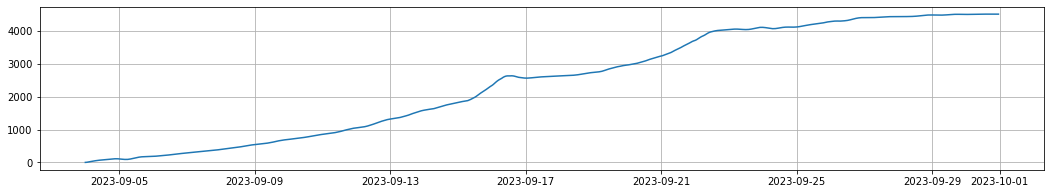

In [23]:
plt.clf()
fig = plt.figure(figsize=(18,3))
plt.plot(dtime_R, energy_wp)
plt.grid()

In [24]:
### load topography data
path_topo = '/Users/chi/Documents/Data/Topography/GEBCO_23_Jan_2025/'
ds_topo = nc.Dataset(path_topo+'gebco_2024_n50.0_s5.0_w-98.0_e-30.0.nc')
# print(ds_topo)
lon_topo = ds_topo.variables['lon'][:]
lat_topo = ds_topo.variables['lat'][:]
elevation = ds_topo.variables['elevation'][:]
print(lon_topo.shape, lat_topo.shape, elevation.shape )

(16320,) (10800,) (10800, 16320)


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_27912/2251491346.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(nrow ,ncol,1)
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_27912/2251491346.py:17: RuntimeWarning: All-NaN slice encountered
  data = np.nanmax( wp, axis=0 )
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_27912/2251491346.py:21: RuntimeWarning: All-NaN slice encountered
  data = np.nanmax( wp, axis=0 ) - np.nanmin( wp, axis=0 )
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_27912/2251491346.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(nrow ,ncol,3)
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_27912/2251491346.py:25: RuntimeWa

<Figure size 432x288 with 0 Axes>

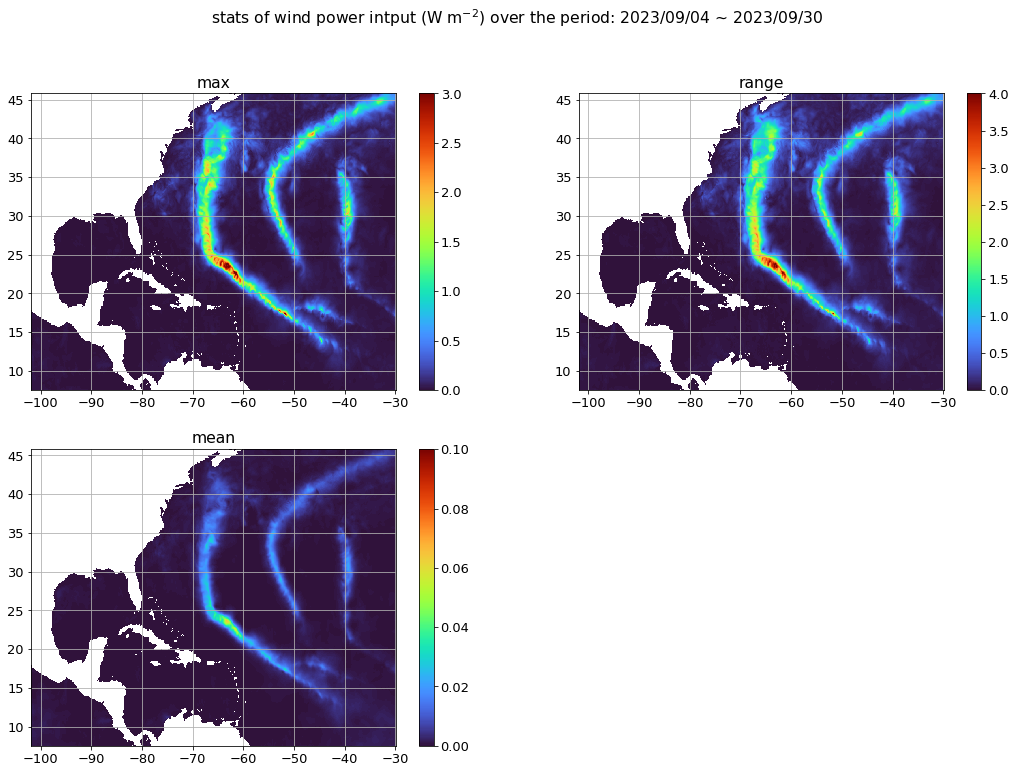

In [25]:
''' Plot map of ... over the selected period
(1) max wind power input
(2) range (max-min) of power input
(3) mean wind power
(4) 
'''
nrow = 2
ncol = 2
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(nrow,1)
fig.set_size_inches(18, 12)
plt.suptitle('stats of wind power intput (W m$^{-2}$) over the period: '+dtime_R[0].strftime('%Y/%m/%d ~ ')+dtime_R[-1].strftime('%Y/%m/%d'))
str_stats = ['max','range','mean']
''' max '''
plt.subplot(nrow ,ncol,1)
data = np.nanmax( wp, axis=0 )
cs = plt.pcolormesh(LON_R, LAT_R, data, cmap='turbo',vmin=0,vmax=3)
''' range '''
plt.subplot(nrow ,ncol,2)
data = np.nanmax( wp, axis=0 ) - np.nanmin( wp, axis=0 )
cs = plt.pcolormesh(LON_R, LAT_R, data, cmap='turbo',vmin=0,vmax=4)
''' mean '''
plt.subplot(nrow ,ncol,3)
data = np.nanmean( wp, axis=0 )
cs = plt.pcolormesh(LON_R, LAT_R, data, cmap='turbo',vmin=0,vmax=0.1)
for i in range( nrow*ncol-1 ):
    plt.subplot(nrow, ncol,i+1)
    plt.colorbar()
    plt.grid()
    if i< len(str_stats):
        plt.title(str_stats[i])
### save figure
plt.savefig('stats_wp({:.2f}f-{:.2f}f)_onMap('.format(n_f[0],n_f[1])+xylim_str+')_'+tlim_str+'.png',dpi=400,bbox_inches='tight')

/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_27912/1816937703.py:2: RuntimeWarning: Mean of empty slice
  wp_mn = np.nanmean( wp, axis=0 )


The total area of the box is 1.147E+13 m^2 = 1.1E+07 km^2
Total area of box with negative wp= 2.89E+11, which accounts for 2.52%
This box input 1.779E-02 TW of power


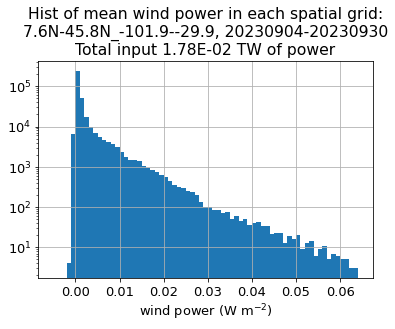

In [63]:
''' compute total area & total input of power to NI motions '''
wp_mn = np.nanmean( wp, axis=0 )
area_m2_total = 0
wp_total = 0
area_m2_total_with_neg_wp = 0 
for i in range( len(LON_R)-1 ):
    for j in range( len(LAT_R)-1 ):
        # print(LON_R[i], LAT_R[j], wp_mn[j,i])
        if np.isnan( wp_mn[j,i] ) == 0: # only account for ocean grids
            obj = {'type':'Polygon','coordinates':[[[LON_R[0,i],LAT_R[j,0]],    [LON_R[0,i],LAT_R[j+1,0]],\
                                                    [LON_R[0,i+1],LAT_R[j+1,0]],[LON_R[0,i+1],LAT_R[j,0]],[LON_R[0,i],LAT_R[j,0]]]]}
            area_m2 = area(obj)
            # print(area_m2)
            area_m2_total = area_m2_total + area_m2
            wp_total = wp_total + wp_mn[j,i]*area_m2
            # break
            ''' if wind power < 0 '''
            if wp_mn[j,i]< 0:
                area_m2_total_with_neg_wp = area_m2_total_with_neg_wp + area_m2
print('The total area of the box is {:.3E} m^2 = {:.1E} km^2'.format(area_m2_total,area_m2_total*1e-6))
print('Total area of box with negative wp= {:.2E}, which accounts for {:.2f}%'.format(area_m2_total_with_neg_wp, area_m2_total_with_neg_wp/area_m2_total*100))
print('This box input {:.3E} TW of power'.format(wp_total*1e-12))

''' plot histogram of mean wind power in each grid '''
plt.clf()
plt.hist(wp_mn.flatten(),np.arange(-0.005,0.065,0.001),log=True);
plt.grid()
plt.xlabel('wind power (W m$^{-2}$)')
plt.title('Hist of mean wind power in each spatial grid:\n'+xylim_str+', '+tlim_str+'\n'\
             +'Total input {:.2E} TW of power'.format(wp_total*1e-12))
plt.savefig('hist_wp-mn_'+tlim_str+'_'+xylim_str+'.png',dpi=300,bbox_inches='tight')

In [64]:
''' Compute TOTAL wind power input (RTOFS spatial grids) '''
wp_total = np.multiply( -UFLX_AVE_onR,U_R ) + np.multiply( -VFLX_AVE_onR,V_R )
''' mean wind power of the box (for each time)'''
wp_total_mn_box = np.nanmean( np.nanmean(wp_total,axis=2), axis=1 )
wp_total_mn_box[0] = 0
wp_total_mn_box[np.isnan(wp_total_mn_box)] = 0 # put NaN values of wind power to 0
''' energy intput integrated over time '''
energy_wp_total = np.zeros( (len(timestamp_wp),) )
for t in range( len(timestamp_wp) ):
    energy_wp_total[t] = np.trapz( wp_total_mn_box[:t+1],timestamp_wp[:t+1] )

/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_27912/4010243171.py:4: RuntimeWarning: Mean of empty slice
  wp_total_mn_box = np.nanmean( np.nanmean(wp_total,axis=2), axis=1 )
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_27912/4010243171.py:10: UserWarning: Warning: converting a masked element to nan.
  energy_wp_total[t] = np.trapz( wp_total_mn_box[:t+1],timestamp_wp[:t+1] )


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_27912/2904283517.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(nrow ,ncol,1)
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_27912/2904283517.py:17: RuntimeWarning: All-NaN axis encountered
  data = np.nanmax( wp_total, axis=0 )
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_27912/2904283517.py:21: RuntimeWarning: All-NaN axis encountered
  data = np.nanmax( wp_total, axis=0 ) - np.nanmin( wp_total, axis=0 )
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_27912/2904283517.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(nrow ,ncol,3)
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_27912/2904283517.

<Figure size 432x288 with 0 Axes>

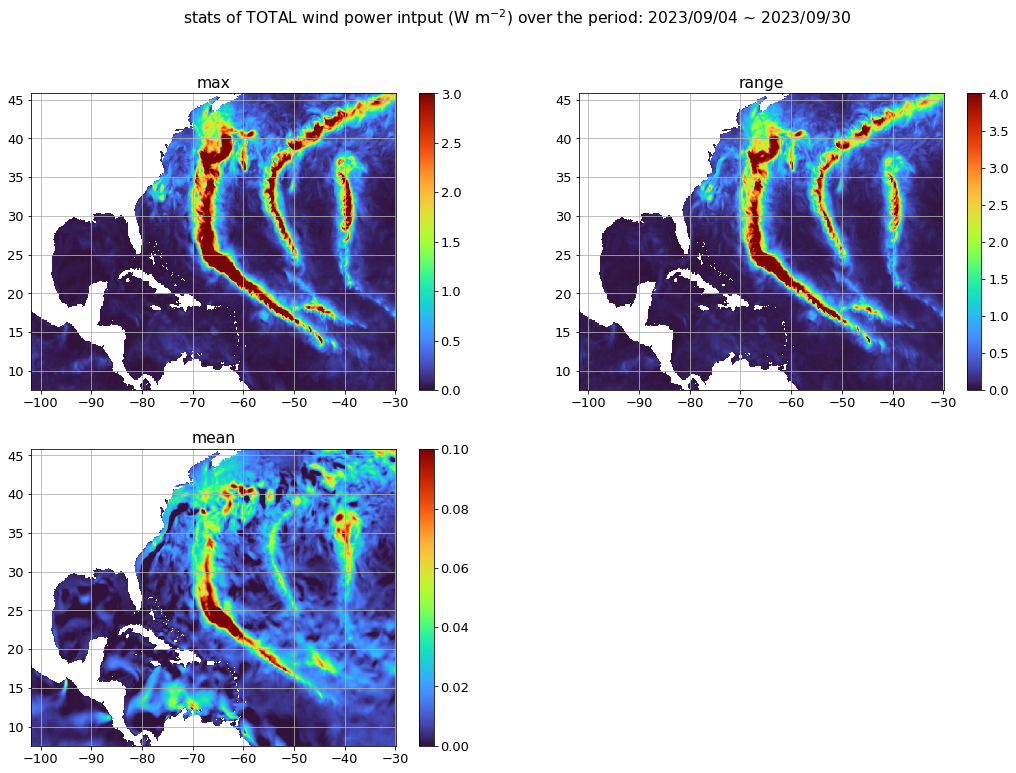

In [41]:
''' Plot map of ... over the selected period
(1) max of total wind power input
(2) range (max-min) of total wind power input
(3) mean of total wind power input
(4) 
'''
nrow = 2
ncol = 2
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(nrow,1)
fig.set_size_inches(18, 12)
plt.suptitle('stats of TOTAL wind power intput (W m$^{-2}$) over the period: '+dtime_R[0].strftime('%Y/%m/%d ~ ')+dtime_R[-1].strftime('%Y/%m/%d'))
str_stats = ['max','range','mean']
''' max '''
plt.subplot(nrow ,ncol,1)
data = np.nanmax( wp_total, axis=0 )
cs = plt.pcolormesh(LON_R, LAT_R, data, cmap='turbo',vmin=0,vmax=3)
''' range '''
plt.subplot(nrow ,ncol,2)
data = np.nanmax( wp_total, axis=0 ) - np.nanmin( wp_total, axis=0 )
cs = plt.pcolormesh(LON_R, LAT_R, data, cmap='turbo',vmin=0,vmax=4)
''' mean '''
plt.subplot(nrow ,ncol,3)
data = np.nanmean( wp_total, axis=0 )
cs = plt.pcolormesh(LON_R, LAT_R, data, cmap='turbo',vmin=0,vmax=0.1)
for i in range( nrow*ncol-1 ):
    plt.subplot(nrow, ncol,i+1)
    plt.colorbar()
    plt.grid()
    if i< len(str_stats):
        plt.title(str_stats[i])
### save figure
plt.savefig('stats_wp_total_onMap('+xylim_str+')_'+tlim_str+'.png',dpi=400,bbox_inches='tight')

/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_27912/41765437.py:2: RuntimeWarning: Mean of empty slice
  wp_total_mn = np.nanmean( wp_total, axis=0 )


The total area of the box is 1.147E+13 m^2 = 1.1E+07 km^2
Total area of box with negative wp= 1.31E+12, which accounts for 11.39%
This box input 1.603E-01 TW of power


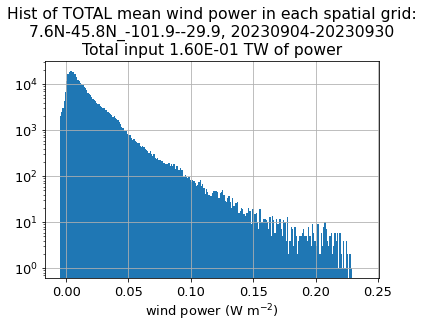

In [ ]:
''' compute total area & total input of TOTAL wind power '''
wp_total_mn = np.nanmean( wp_total, axis=0 )
area_m2_total = 0
wp_total_total = 0
area_m2_total_with_neg_wp = 0
for i in range( len(LON_R)-1 ):
    for j in range( len(LAT_R)-1 ):
        # print(LON_R[i], LAT_R[j], wp_total_mn[j,i])
        if np.isnan( wp_total_mn[j,i] ) == 0: # only account for ocean grids
            obj = {'type':'Polygon','coordinates':[[[LON_R[0,i],LAT_R[j,0]],    [LON_R[0,i],LAT_R[j+1,0]],\
                                                    [LON_R[0,i+1],LAT_R[j+1,0]],[LON_R[0,i+1],LAT_R[j,0]],[LON_R[0,i],LAT_R[j,0]]]]}
            area_m2 = area(obj)
            # print(area_m2)
            area_m2_total = area_m2_total + area_m2
            wp_total_total = wp_total_total + wp_total_mn[j,i]*area_m2
            # break
            ''' if wind power < 0 '''
            if wp_total_mn[j,i]< 0:
                area_m2_total_with_neg_wp = area_m2_total_with_neg_wp + area_m2
print('The total area of the box is {:.3E} m^2 = {:.1E} km^2'.format(area_m2_total,area_m2_total*1e-6))
print('Total area of box with negative wp= {:.2E}, which accounts for {:.2f}%'.format(area_m2_total_with_neg_wp, area_m2_total_with_neg_wp/area_m2_total*100))
print('This box input {:.3E} TW of power'.format(wp_total_total*1e-12))

''' plot histogram of mean wind power in each grid '''
plt.clf()
plt.hist(wp_total_mn.flatten(),np.arange(-0.005,0.24,0.001),log=True);
plt.grid()
plt.xlabel('wind power (W m$^{-2}$)')
plt.title('Hist of TOTAL mean wind power in each spatial grid:\n'+xylim_str+', '+tlim_str+'\n'\
             +'Total input {:.2E} TW of power'.format(wp_total_total*1e-12))
plt.savefig('hist_wp-mn-total_'+tlim_str+'_'+xylim_str+'.png',dpi=300,bbox_inches='tight')

/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_27912/903342502.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(nrow ,ncol,1)
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_27912/903342502.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('turbo').copy()


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

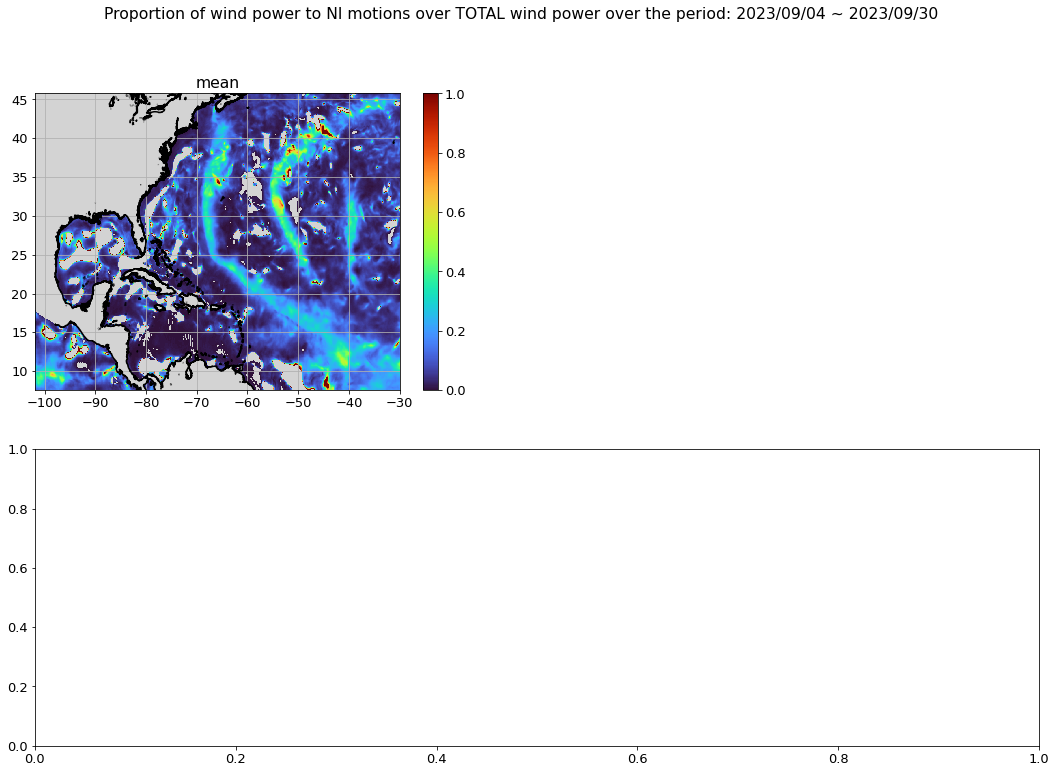

In [71]:
''' plot the percentage of "mean wp to NI motions" over "total mean power" '''
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(nrow,1)
nrow = 2
ncol = 2
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(nrow,1)
fig.set_size_inches(18, 12)
plt.suptitle('Proportion of wind power to NI motions over TOTAL wind power over the period: '+dtime_R[0].strftime('%Y/%m/%d ~ ')+dtime_R[-1].strftime('%Y/%m/%d'))
str_stats = ['mean']
plt.subplot(nrow ,ncol,1)
data = np.divide(wp_mn,wp_total_mn)
data = np.ma.masked_where( data< 0, data )
cmap = matplotlib.cm.get_cmap('turbo').copy()
cmap.set_bad(color='lightgray')
cs = plt.pcolormesh(LON_R, LAT_R, data, cmap=cmap,vmin=0,vmax=1)
for i in range( 1 ):
    plt.subplot(nrow, ncol,i+1)
    plt.colorbar()
    plt.grid()
    ''' plot land borders '''
    plt.contour(lon_topo, lat_topo, elevation, levels=[0], colors='k')
    plt.xlim([np.min(LON_R),np.max(LON_R)])
    plt.ylim([np.min(LAT_R),np.max(LAT_R)])
    if i< len(str_stats):
        plt.title(str_stats[i])
plt.savefig('proportion_wp({:.2f}f-{:.2f}f)over-total_onMap('.format(n_f[0],n_f[1])+xylim_str+')_'+tlim_str+'.png',dpi=400,bbox_inches='tight')